# Image processing

In [1]:
import pytesseract
import cv2

In [2]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
from matplotlib import pyplot as plt
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

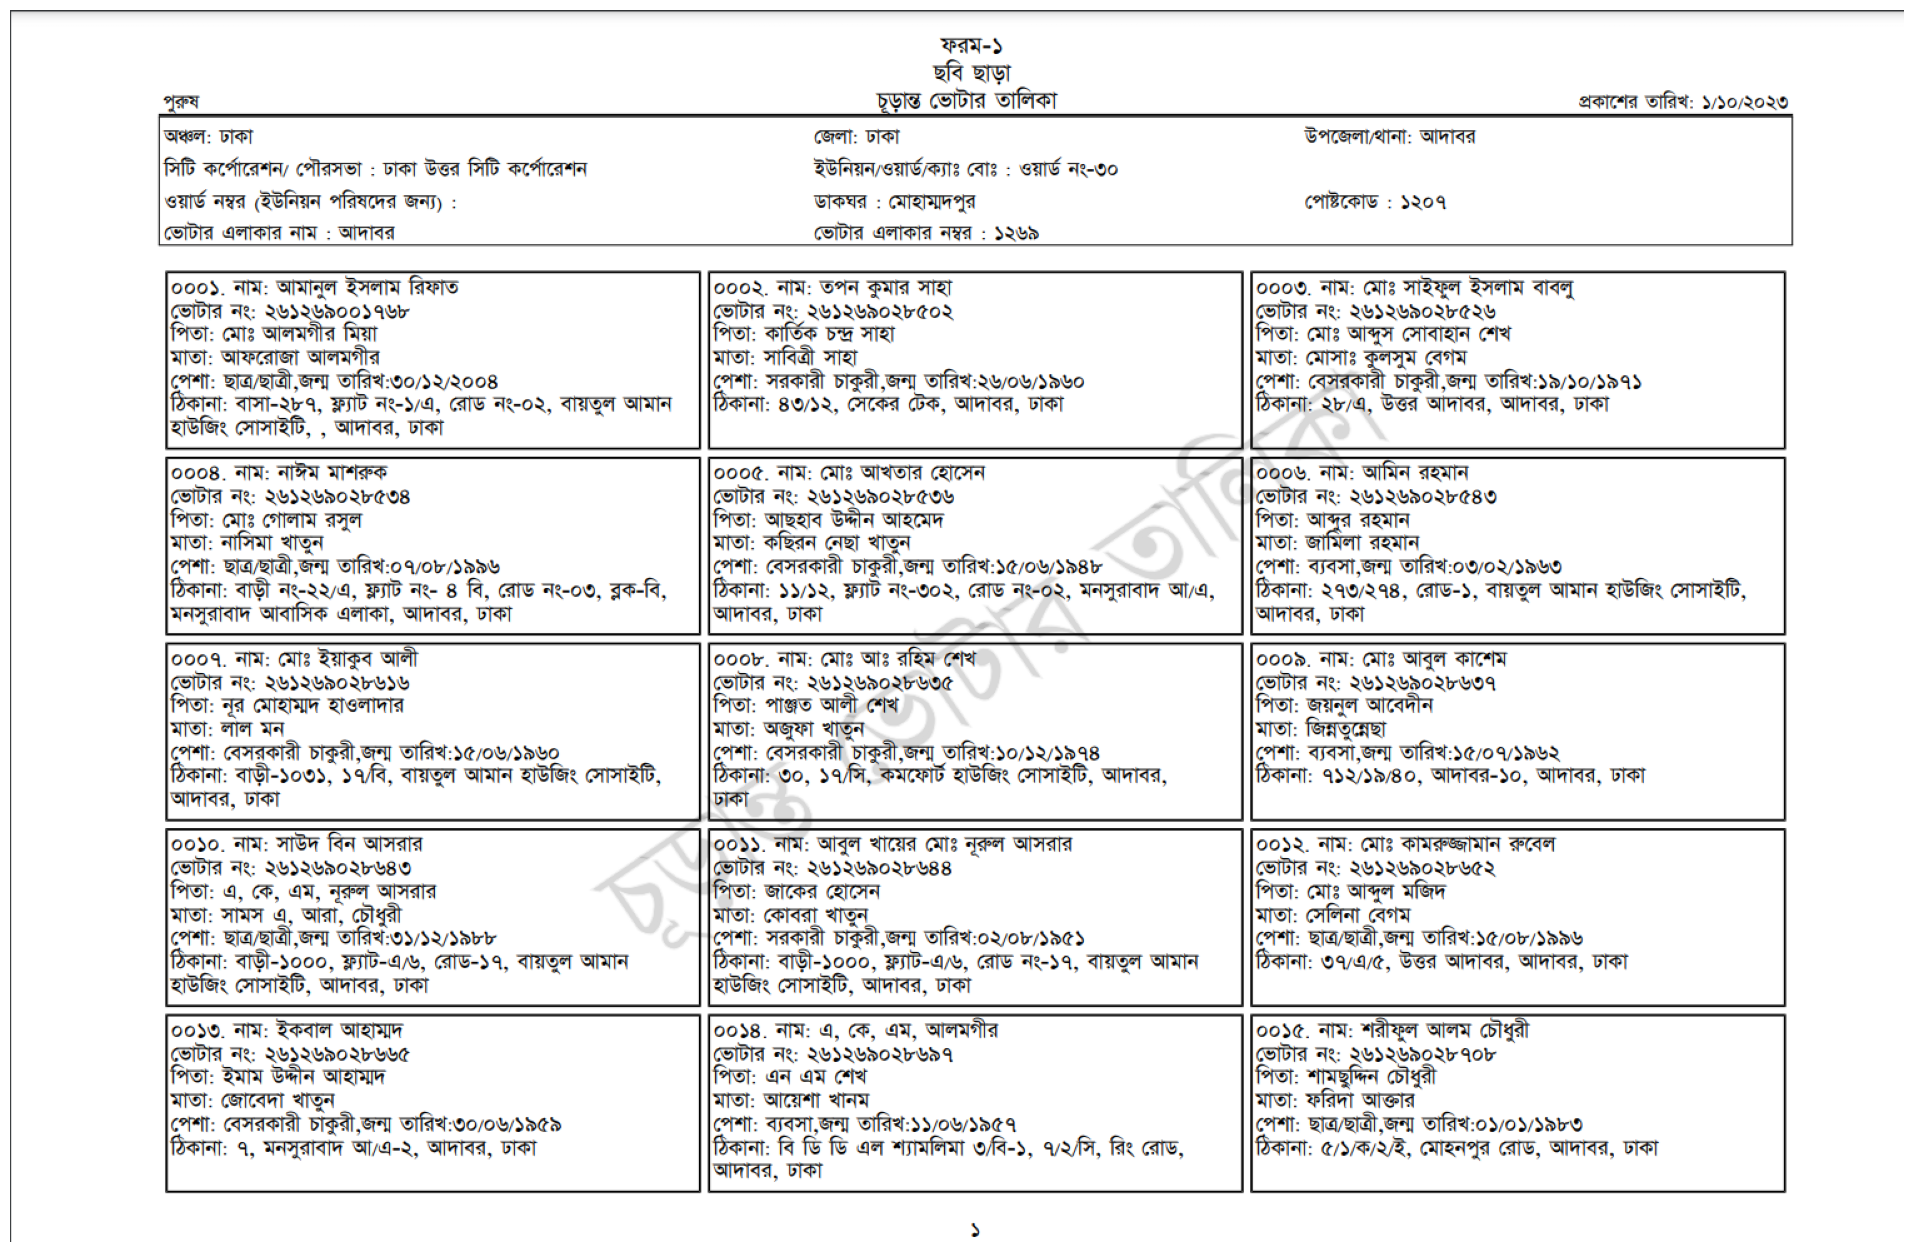

In [3]:
image_file = "data/page1.png"
img = cv2.imread(image_file)
display(image_file)

In [4]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
gray_image = grayscale(img)
cv2.imwrite("temp/gray.jpg", gray_image)

True

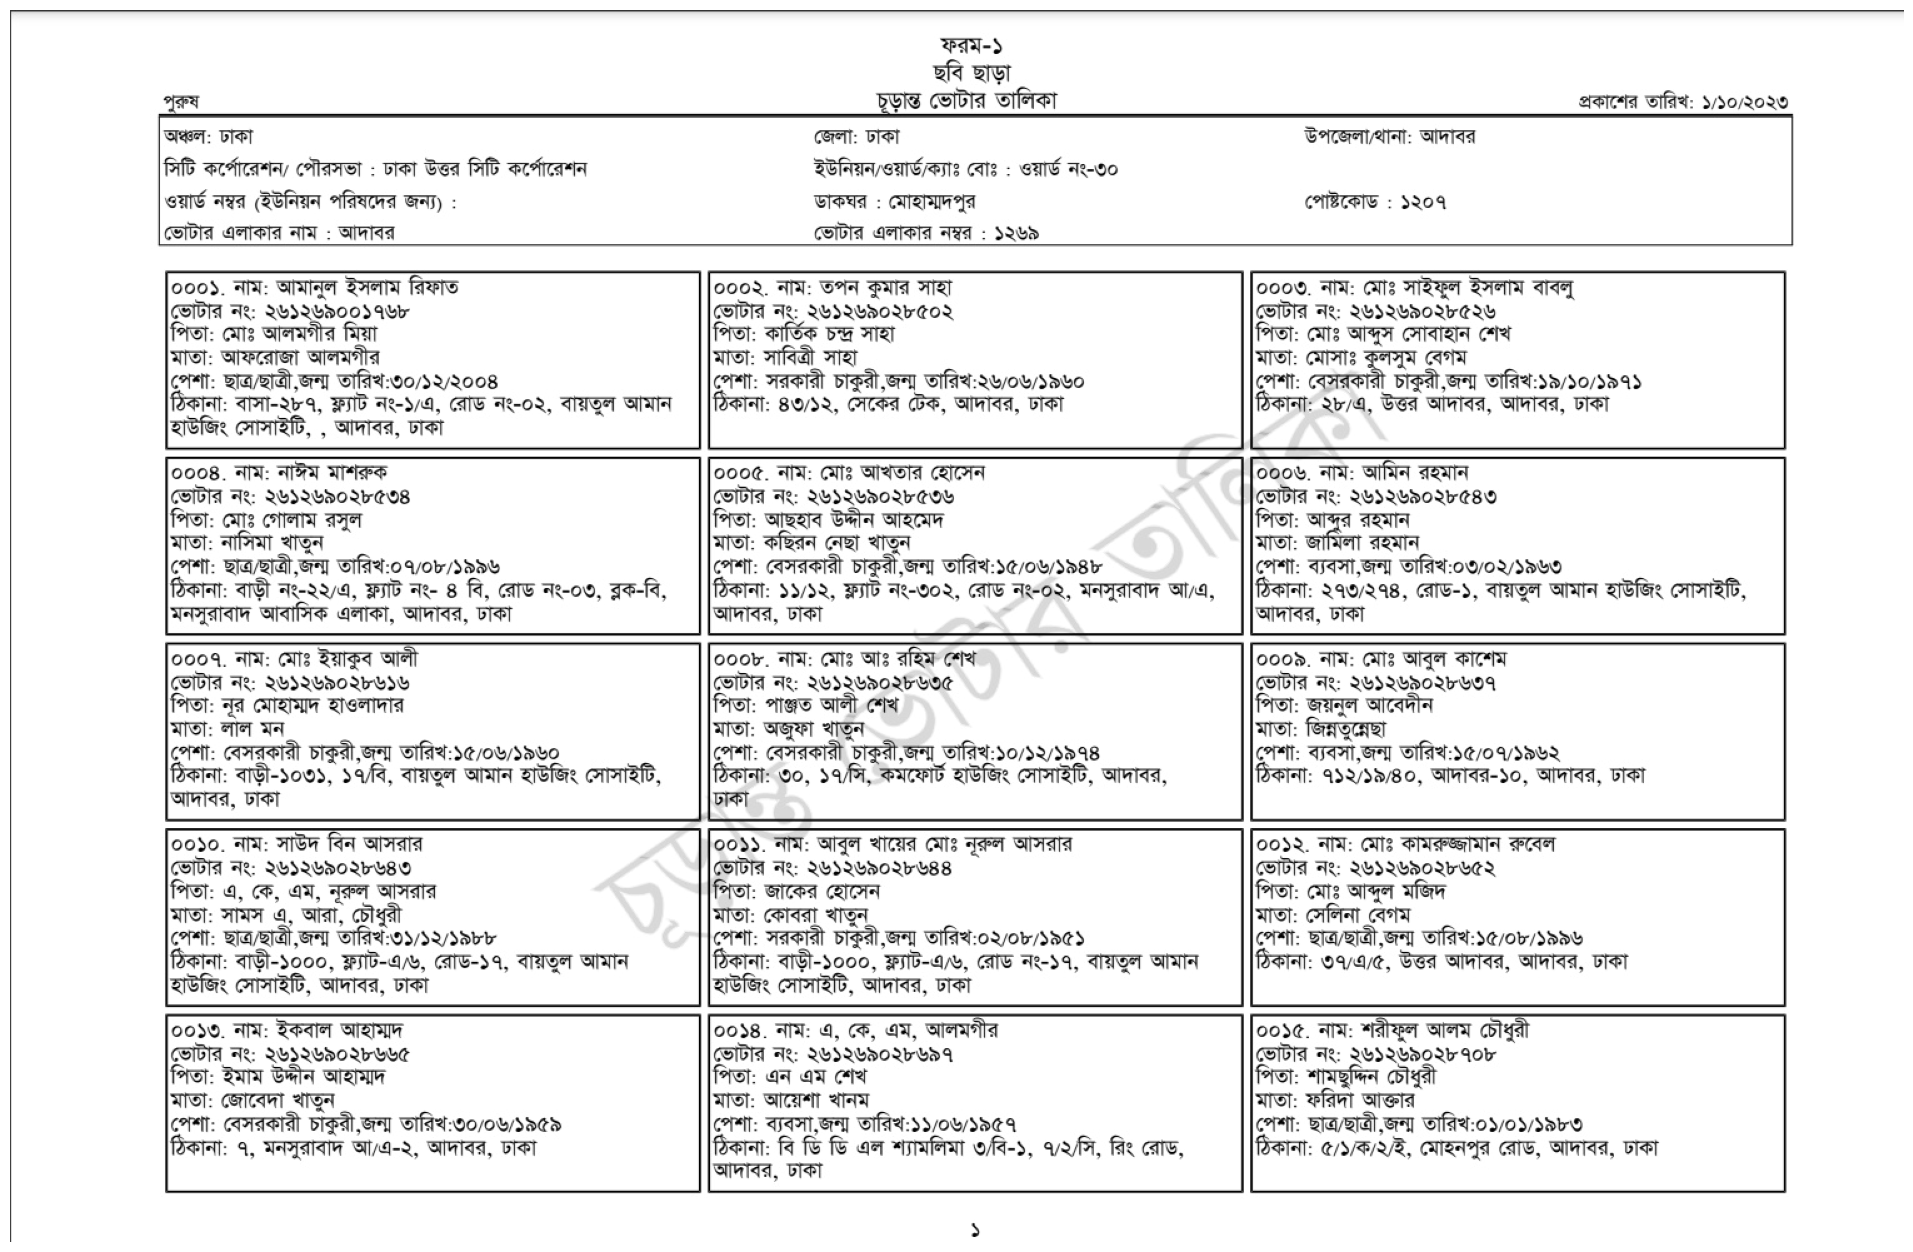

In [6]:
display("temp/gray.jpg")

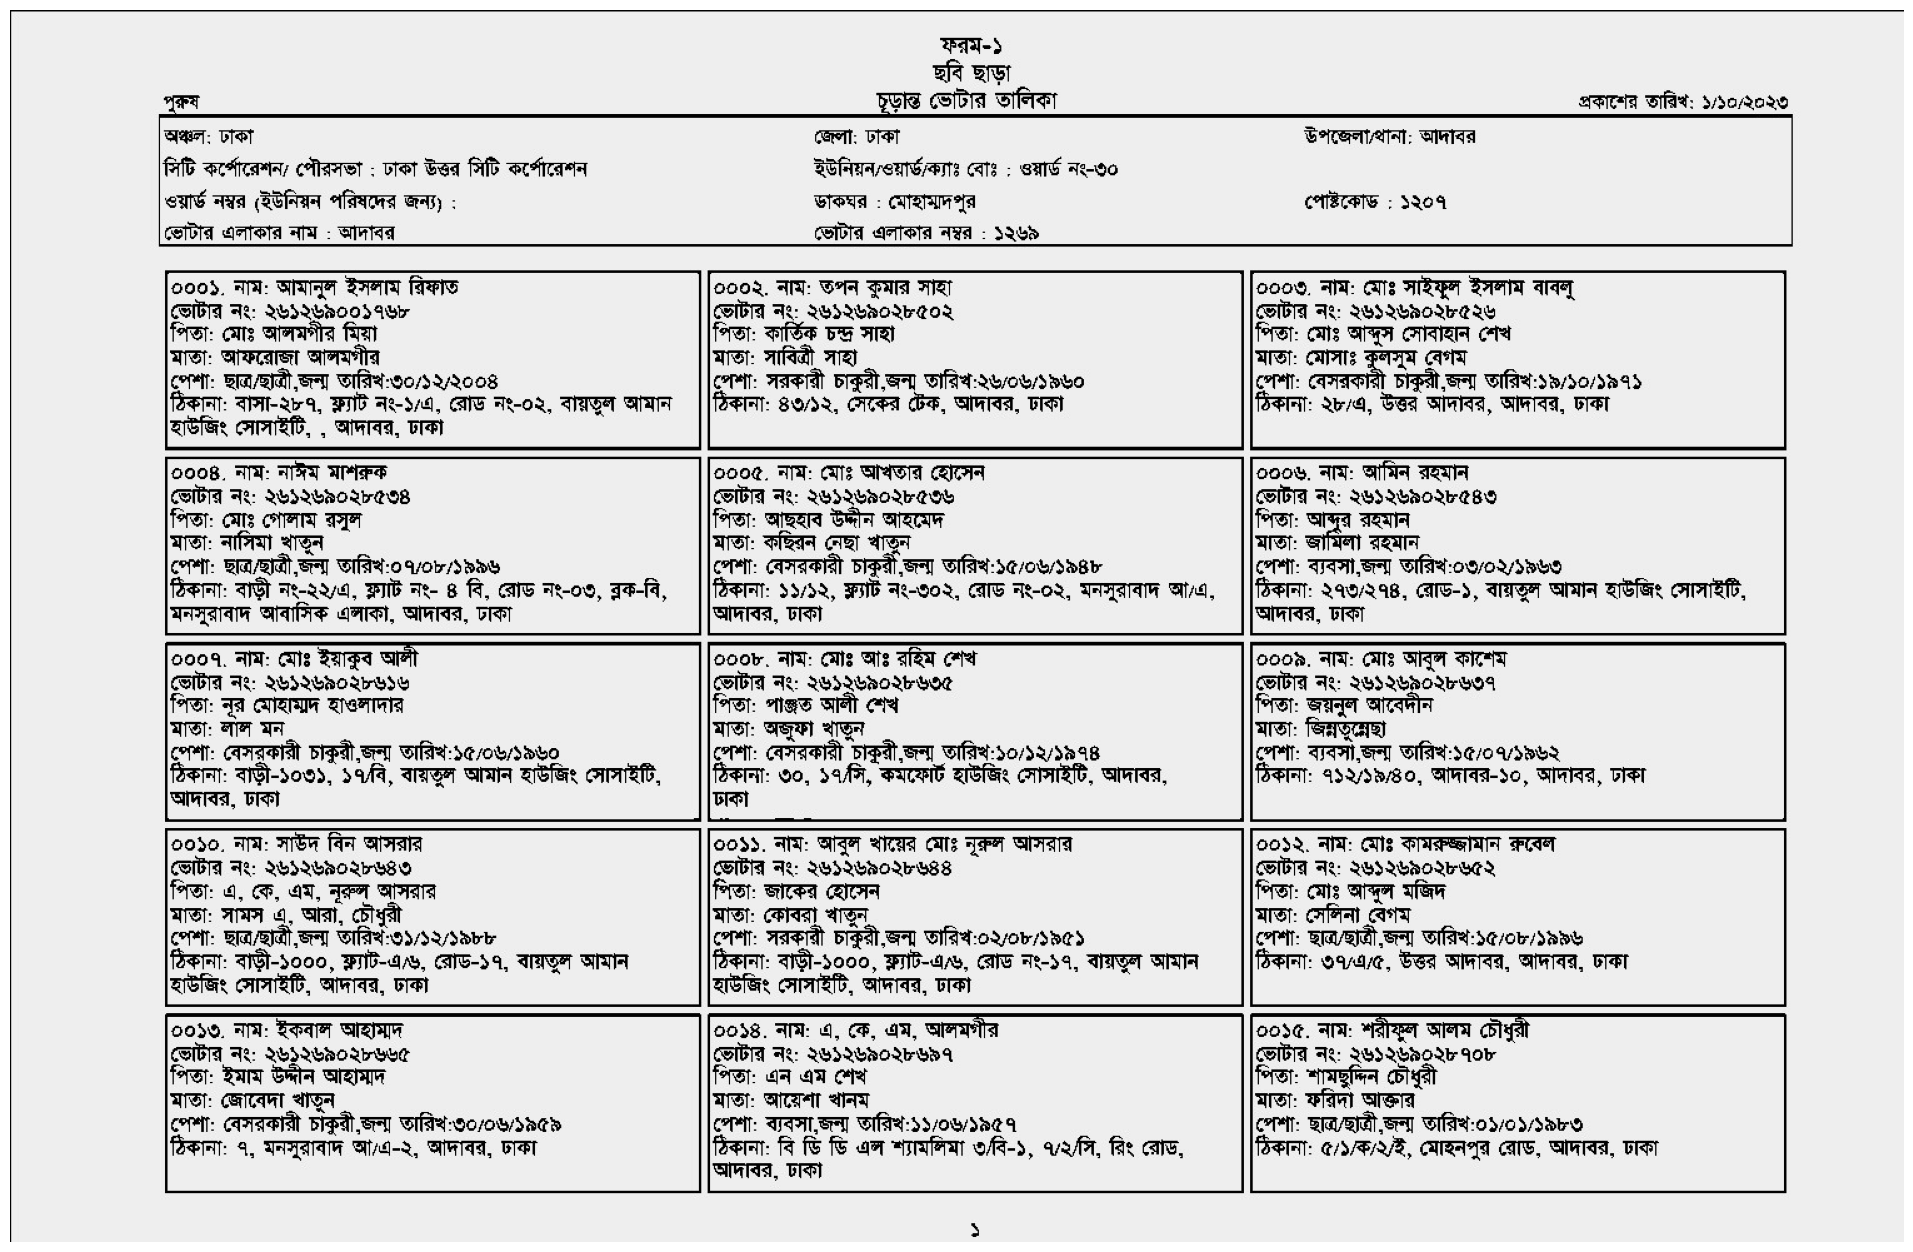

In [7]:
thresh, im_bw = cv2.threshold(gray_image, 180, 120, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image.jpg", im_bw)
display("temp/bw_image.jpg")

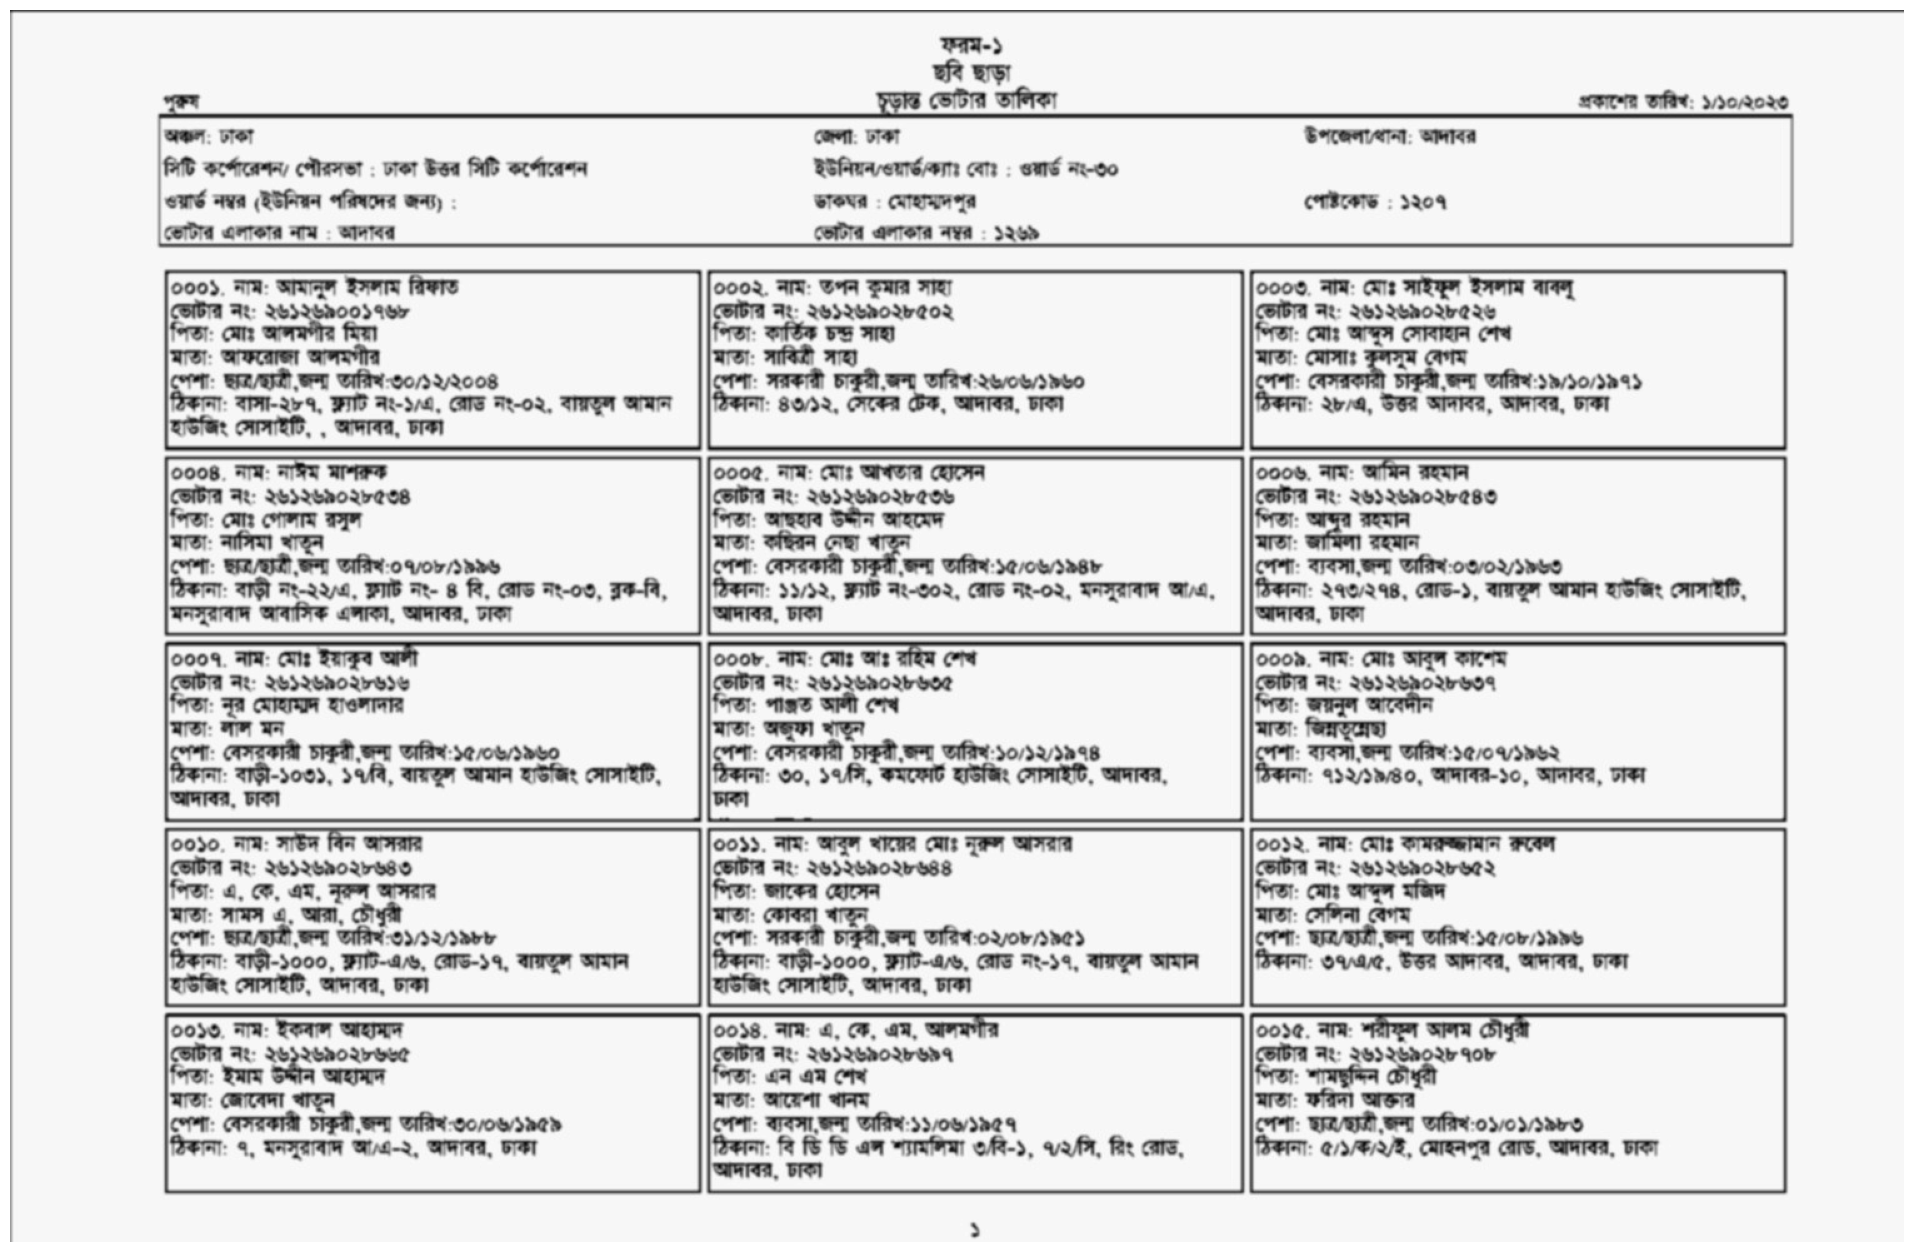

In [8]:
blur = cv2.GaussianBlur(im_bw, (5,5), 0)
cv2.imwrite("temp/index_blur.jpg", blur)
display("temp/index_blur.jpg")

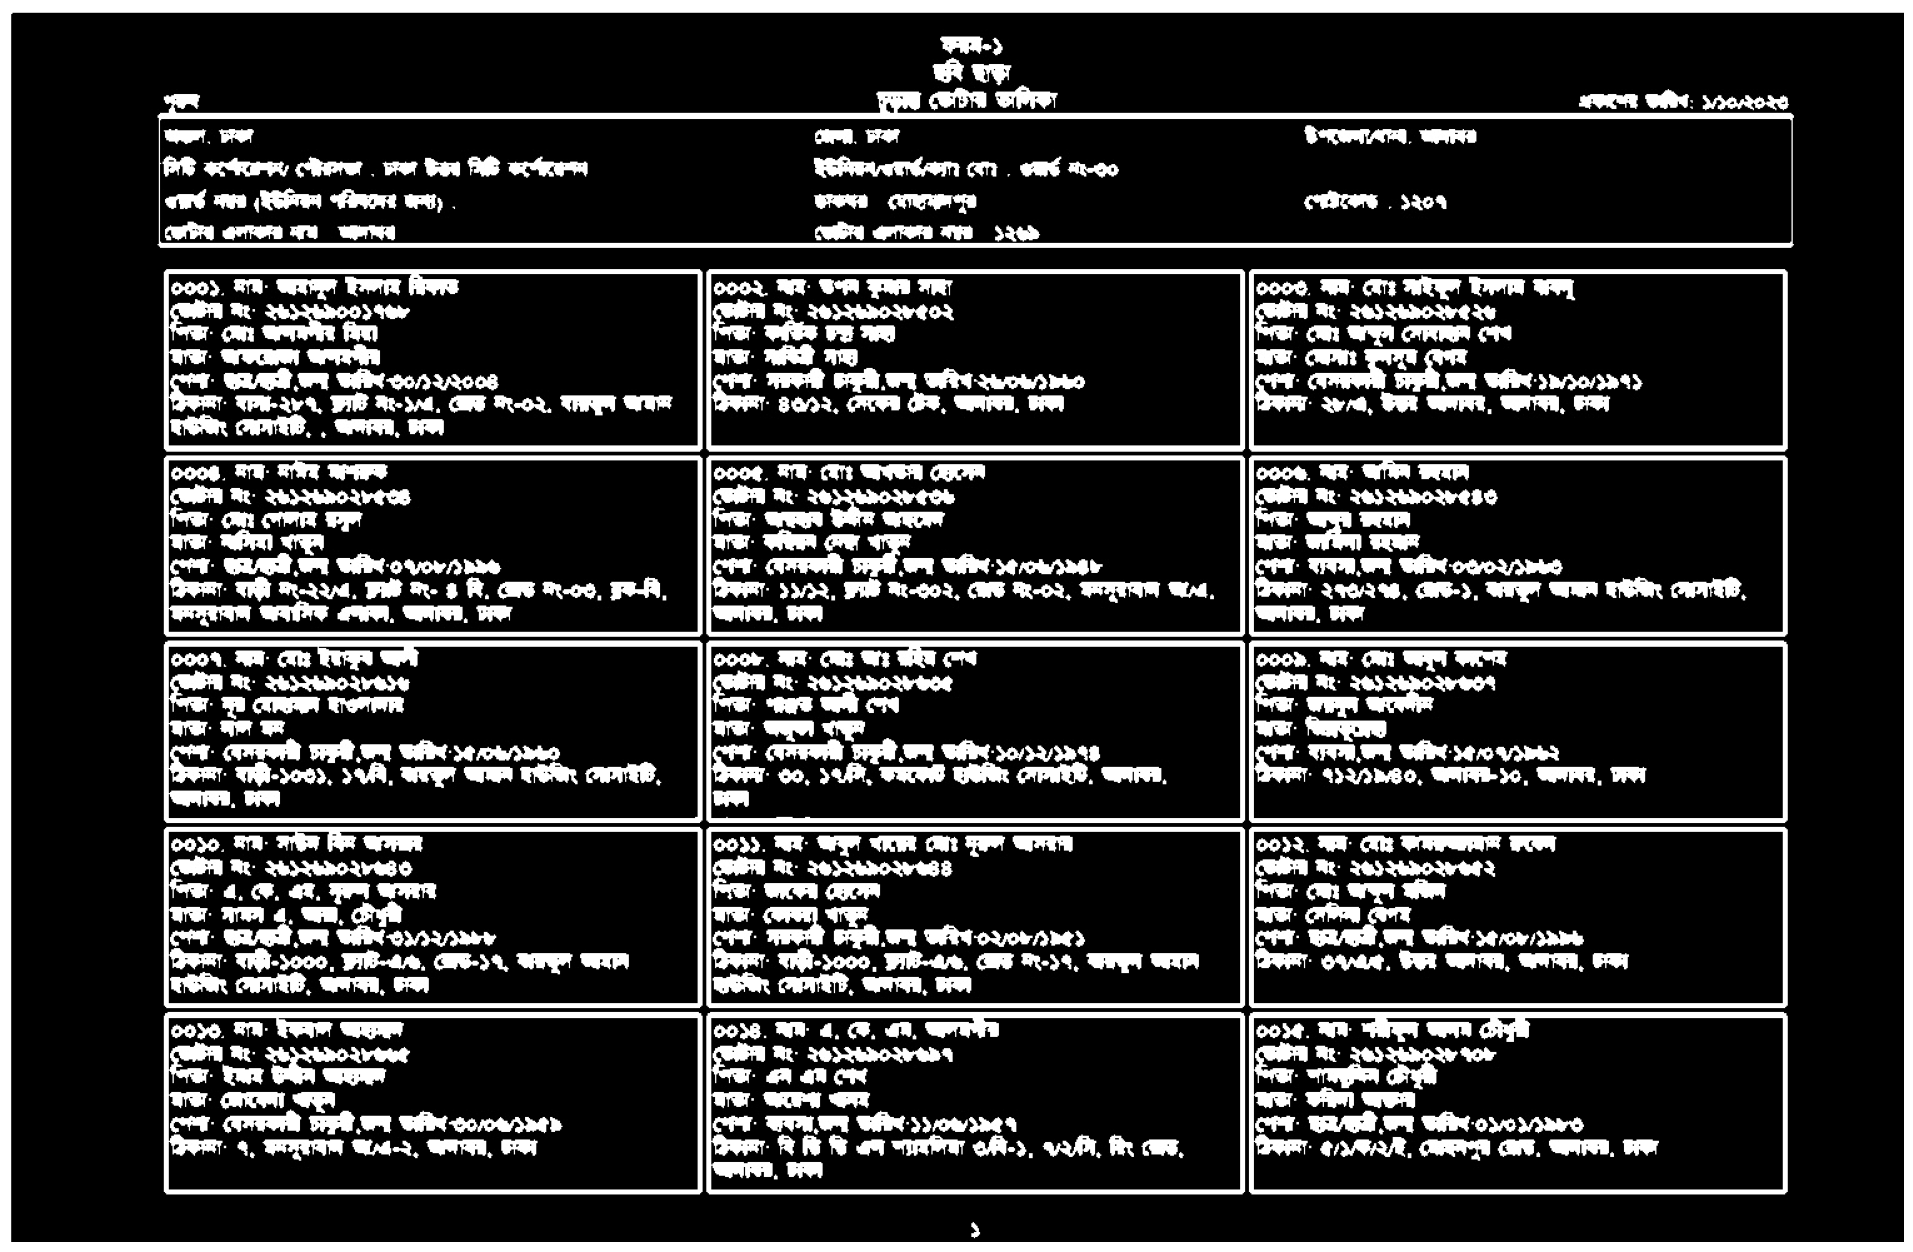

In [9]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.imwrite("temp/index_thresh.jpg", thresh)
display("temp/index_thresh.jpg")

In [10]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [11]:
cnts = cnts[0] if len(cnts) == 2 else cnts[2]

In [12]:
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

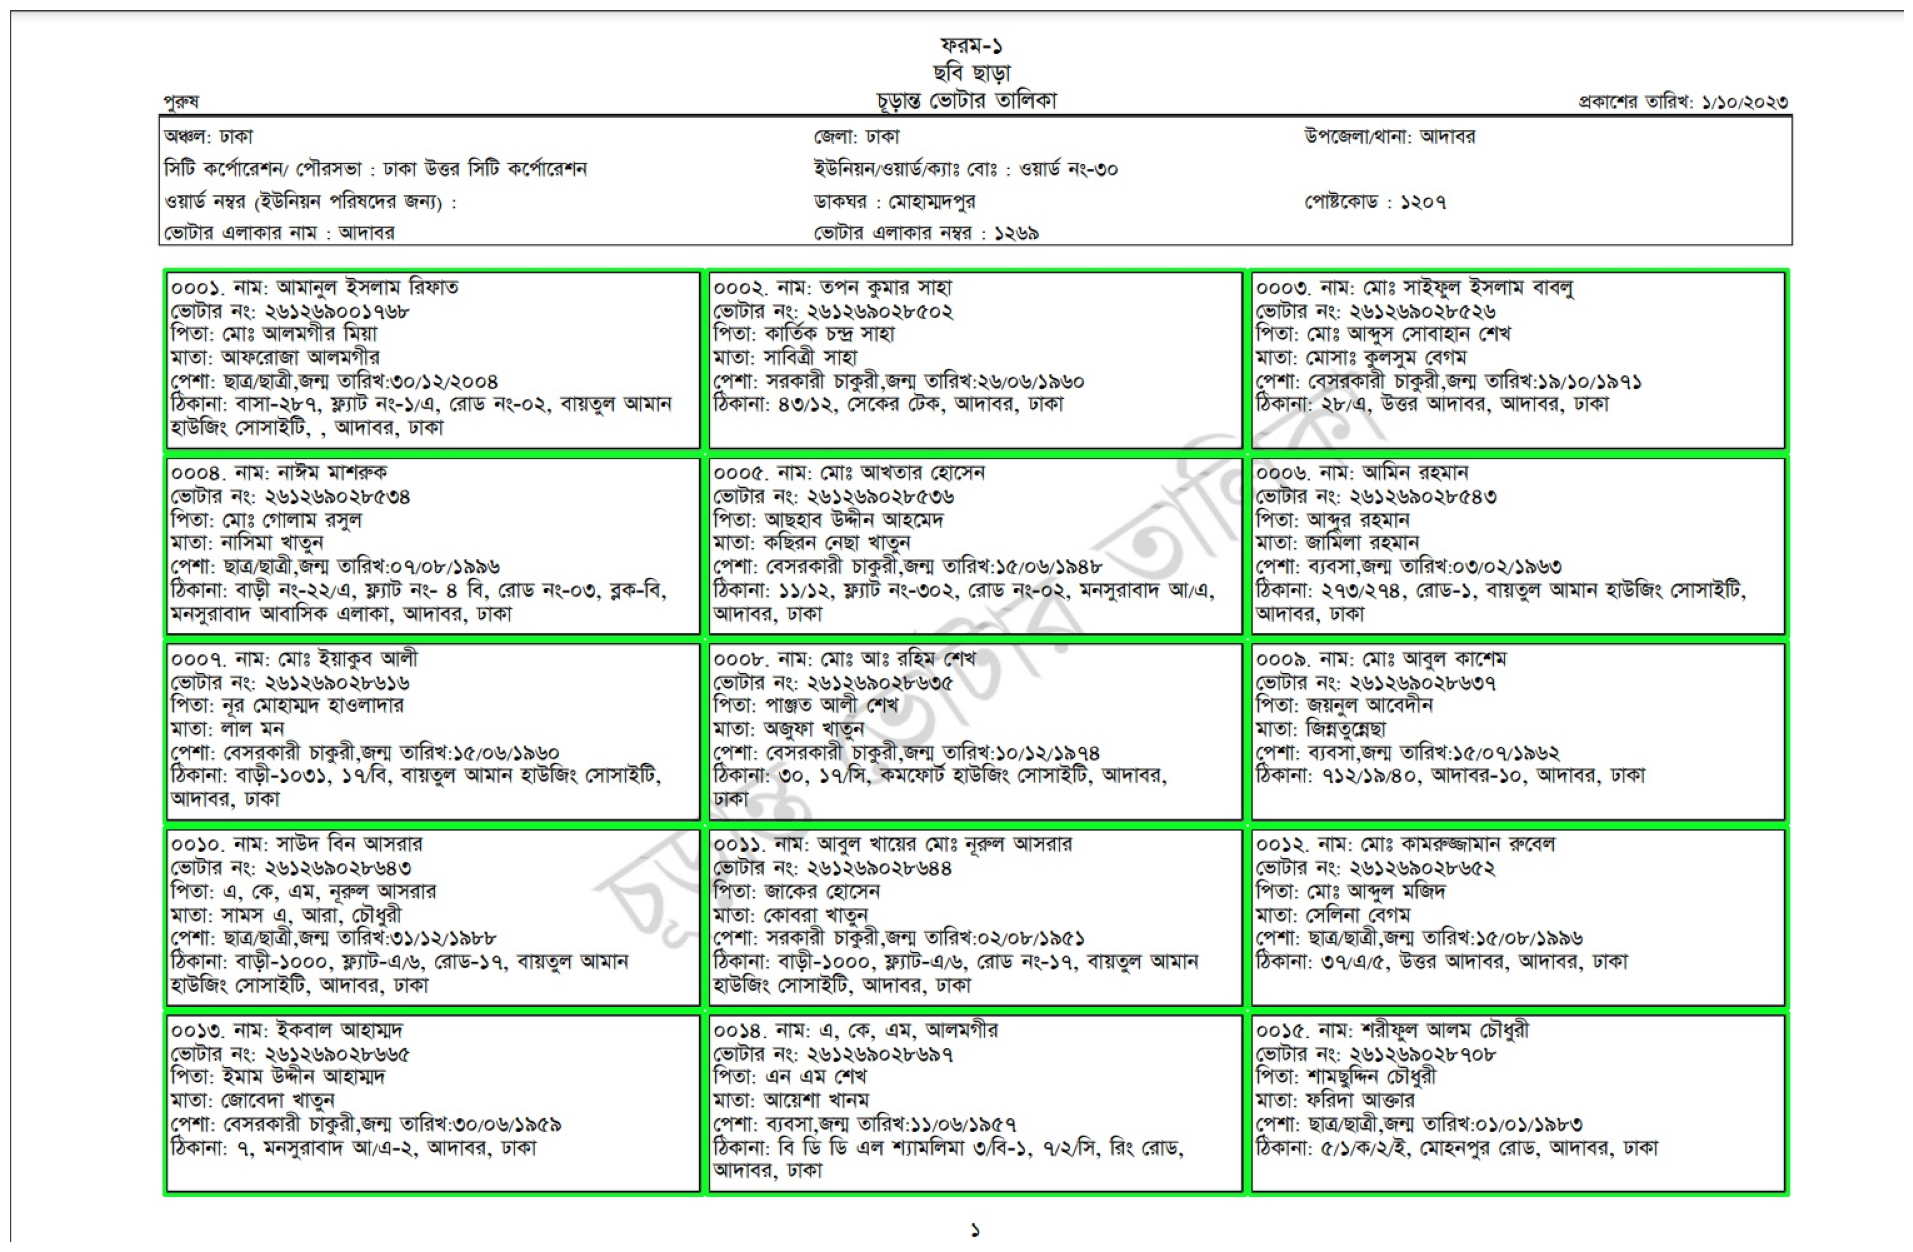

In [13]:
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 20 and w < 600:
        cv2.rectangle(img, (x, y), (x+w, y+h), (36, 255, 12), 2)
    
cv2.imwrite("temp/index_bbox.jpg", img)

display("temp/index_bbox.jpg")

# Data Processing

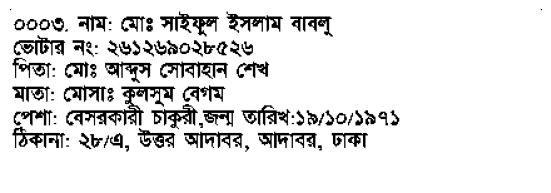

In [14]:
results = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 20 and w < 600:
        filtered_list = []
        roi = im_bw[y+3:y+h-4, x+3:x+w-3]
        cv2.imwrite("temp/index_roi.png", roi)
        cv2.rectangle(im_bw, (x, y), (x+w, y+h), (36, 255, 12), 1)
        ocr_result = pytesseract.image_to_string(roi, lang='ben')
        ocr_result = ocr_result.split("\n")
        ocr_result = [item for item in ocr_result if item != '']
        
        filtered_list.append(ocr_result[0].split('নাম')[0].replace(' ', '').replace('.', ''))
        
        filtered_list.append(ocr_result[0].split('নাম')[1].replace(':', '').replace(';', ''))
        
        filtered_list.append(ocr_result[1].split('ভোটার নং')[1].replace(':', ''))
        
        if 'পিতা' in ocr_result[2]:
            filtered_list.append(ocr_result[2].split('পিতা')[1].replace(':', '').replace(';', ''))
        else:
            ocr_result[2] = ocr_result[2].replace(ocr_result[2].split(' ')[0], 'পিতা')
            filtered_list.append(ocr_result[2].replace('পিতা', '').replace(':', '').replace(';', ''))
            
        if 'মাতা' in ocr_result[3]:
            filtered_list.append(ocr_result[3].split('মাতা')[1].replace(':', '').replace(';', ''))
        else:
            ocr_result[3] = ocr_result[3].replace(ocr_result[3].split(' ')[0], 'মাতা')
            filtered_list.append(ocr_result[3].replace('মাতা', '').replace(':', '').replace(';', ''))    
                    
        filtered_list.append(''.join(ocr_result[4].split(' তারিখ')[0].replace('পেশা', '').replace(':', '').replace(';', ''))[:-4])
        
        filtered_list.append(ocr_result[4].split(' তারিখ')[1].replace(':', '').replace(';', ''))
        
        address = ''
        for i in range(len(ocr_result)-5):
            address = address + ocr_result[5+i]
        filtered_list.append(address.replace(':', '').replace('ঠিকানা', ''))
            
        
        # print(ocr_result)
        # print(filtered_list)
        results.append(filtered_list)
        
    
display("temp/index_roi.png")

In [15]:
print(results)

[['০০১৩', ' ইকবাল SIA', ' ২৬২৬৯০২৮৬৬৫', ' ইমাম উদ্দান আহাম্মদ', ' জোবেদা খাতুন', ' বেসরকারী চাকুরী.', '৩০/০৬/১৯৫৯', ' ৭, মনসুরাবাদ আ/এ-২, আদাবর, ঢাকা'], ['০০১০', ' সাউদ বিন আসরার', ' ২৬১২৬৯০২৮৬৪৩', ' এ, কে, এম, নূরুল আসরার', ' সামস এ. আরা, চৌধুরী', ' ছাত্র/ছাত্রী ', '৩১/১২/১৯৮৮', ' বাড়ী-১০০০, ফ্ল্যাট-এ/৬, রোড-১৭, বায়তুল আমানহাউজিং সোসাইটি, আদাবর, ঢাকা'], ['০০০৭', ' ইয়াকুব আলী', ' ২৬১২৬৯০২৮৬১৬', ' নূর মোহাম্মদ হাওলাদার', ' লাল মন.', ' বেসরকারী চাকুরী.', '১৫/০৬/১৯৬০', ' বাড়ী-১০৩১, 5944, বায়তুল আমান হাউজিং সোসাইটি,আদাবর, ঢাকা'], ['০০০৪', ' নাঈম মাশরুক', ' ২৬১২৬৯০২৮৫৩৪', ' মোঃ গোলাম রসুল', ' নাসিমা খাতুন', ' ছাত্র/ছাত্রী. ', '০৭/০৮/১৯৯৬', ' বাড়ী নং-২২/এ, ফ্ল্যাট নং- ৪ বি, রোড নং-০৩, ব্লক-বি,মনসুরাবাদ আবাসিক এলাকা, আদাবর, ঢাকা'], ['০০০১', ' আমানুল ইসলাম রিফাত', ' ২৬১২৬৯০০১৭৬৮', ' মোঃ আলমগীর মিয়া', ' আফরোজা আলমগীর', ' ছাত্র/ছাত্রী ', '৩০/১২/২০০৪', ' বাসা-২৮৭, ফ্ল্যাট নং-১/এ, রোড নং-০২, বায়তুল আমানহাউজিং সোসাইটি, , আদাবর, ঢাকা'], ['০০১৪', ' এ, কে, এম, আলমগীর', ' ২৬১২৬৯০২৮৬৯৭', ' এন এম

#  Working with CSV

In [16]:
import pandas as pd
import numpy as np
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

In [17]:
sl, name, voter, father, mother, occupation, birthday, address = [],[],[],[],[],[],[],[]

In [18]:
for i in range(len(results)):
    sl.append(results[i][0])
    name.append(results[i][1])
    voter.append(results[i][2])
    father.append(results[i][3])
    mother.append(results[i][4])
    occupation.append(results[i][5])
    birthday.append(results[i][6])
    address.append(results[i][7])

In [19]:
data = {
    "SL No": sl,
    "Name": name,
    "Voter No": voter,
    "Father": father,
    "Mother": mother,
    "Occupation": occupation,
    "Birthday": birthday,
    "Address": address
}

In [20]:
data

{'SL No': ['০০১৩',
  '০০১০',
  '০০০৭',
  '০০০৪',
  '০০০১',
  '০০১৪',
  '০০১১',
  '০০০৮',
  '০০০৫',
  '০০০২',
  '০০১৫',
  '০০১২',
  '০০০৯',
  '০০০৬',
  '০০০৩'],
 'Name': [' ইকবাল SIA',
  ' সাউদ বিন আসরার',
  ' ইয়াকুব আলী',
  ' নাঈম মাশরুক',
  ' আমানুল ইসলাম রিফাত',
  ' এ, কে, এম, আলমগীর',
  ' আবুল খায়ের মোঃ নূরুল আসরার',
  ' মোঃ আঃ রহিম শেখ',
  ' মোঃ আখতার হোসেন',
  ' তপন কুমার সাহা',
  ' শরীফুল আলম চৌধুরী',
  ' মোঃ কামরুজ্জামান রুবেল',
  ' মোঃ আবুল কাশেম',
  ' আমিন রহমান',
  ' মোঃ সাইফুল ইসলাম বাবলু'],
 'Voter No': [' ২৬২৬৯০২৮৬৬৫',
  ' ২৬১২৬৯০২৮৬৪৩',
  ' ২৬১২৬৯০২৮৬১৬',
  ' ২৬১২৬৯০২৮৫৩৪',
  ' ২৬১২৬৯০০১৭৬৮',
  ' ২৬১২৬৯০২৮৬৯৭',
  ' ২৬১২৬৯০২৮৬৪৪',
  ' ২৬১২৬৯০২৮৬৩৫',
  ' ২৬১২৬৯০২৮৫৩৬',
  ' ২৬১২৬৯০২৮৫০২',
  ' ২৬১২৬৯০২৮৭০৮',
  ' ২৬১২৬৯০২৮৬৫২',
  ' ২৬১২৬০২৮৬৩৭',
  ' ২৬১২৬৯০২৮৫৪৩',
  ' ২৬১২৬৯০২৮৫২৬'],
 'Father': [' ইমাম উদ্দান আহাম্মদ',
  ' এ, কে, এম, নূরুল আসরার',
  ' নূর মোহাম্মদ হাওলাদার',
  ' মোঃ গোলাম রসুল',
  ' মোঃ আলমগীর মিয়া',
  ' এন এম শেখ',
  ' জাকের হোসেন',
  ' পাঞ্জত আলী শেখ',
  

In [21]:
df = pd.DataFrame(data)

In [22]:
print(df)

   SL No                          Name       Voter No  \
0   ০০১৩                     ইকবাল SIA    ২৬২৬৯০২৮৬৬৫   
1   ০০১০                সাউদ বিন আসরার   ২৬১২৬৯০২৮৬৪৩   
2   ০০০৭                   ইয়াকুব আলী   ২৬১২৬৯০২৮৬১৬   
3   ০০০৪                   নাঈম মাশরুক   ২৬১২৬৯০২৮৫৩৪   
4   ০০০১            আমানুল ইসলাম রিফাত   ২৬১২৬৯০০১৭৬৮   
5   ০০১৪             এ, কে, এম, আলমগীর   ২৬১২৬৯০২৮৬৯৭   
6   ০০১১   আবুল খায়ের মোঃ নূরুল আসরার   ২৬১২৬৯০২৮৬৪৪   
7   ০০০৮               মোঃ আঃ রহিম শেখ   ২৬১২৬৯০২৮৬৩৫   
8   ০০০৫               মোঃ আখতার হোসেন   ২৬১২৬৯০২৮৫৩৬   
9   ০০০২                তপন কুমার সাহা   ২৬১২৬৯০২৮৫০২   
10  ০০১৫             শরীফুল আলম চৌধুরী   ২৬১২৬৯০২৮৭০৮   
11  ০০১২        মোঃ কামরুজ্জামান রুবেল   ২৬১২৬৯০২৮৬৫২   
12  ০০০৯                মোঃ আবুল কাশেম    ২৬১২৬০২৮৬৩৭   
13  ০০০৬                    আমিন রহমান   ২৬১২৬৯০২৮৫৪৩   
14  ০০০৩        মোঃ সাইফুল ইসলাম বাবলু   ২৬১২৬৯০২৮৫২৬   

                     Father                Mother          Occupation  \
0       ইমাম উ

In [23]:
df.to_csv("result/output.csv", index=False, encoding='utf-8-sig')